# GPU Regressions
by Martin Popovski

Data: https://www.kaggle.com/iliassekkaf/computerparts?select=All_GPUs.csv

## Data cleaning

In [1]:
import pandas as pd
import math
import re

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df1 = pd.read_csv('data/All_GPUs.csv')

In [4]:
df1

Architecture Best_Resolution Boost_Clock Core_Speed  DVI_Connection  \
0     Tesla G92b              NaN         NaN    738 MHz             2.0   
1        R600 XT       1366 x 768         NaN       \n-              2.0   
2       R600 PRO       1366 x 768         NaN       \n-              2.0   
3          RV630       1024 x 768         NaN       \n-              2.0   
4          RV630       1024 x 768         NaN       \n-              2.0   
...           ...             ...         ...        ...             ...   
3401       MCP61              NaN         NaN       \n-              1.0   
3402       MCP61              NaN         NaN       \n-              0.0   
3403       MCP51              NaN         NaN       \n-              0.0   
3404       MCP51              NaN         NaN       \n-              NaN   
3405        NV43              NaN         NaN       \n-              1.0   

     Dedicated Direct_X  DisplayPort_Connection  HDMI_Connection Integrated  \
0          Yes  DX 10.0                     NaN              0.0         No   
1          Yes    DX 10                     NaN              0.0         No   
2          Yes    DX 10                     NaN              0.0         No   
3          Yes    DX 10                     NaN              0.0         No   
4          Yes    DX 10                     NaN              0.0         No   
...        ...      ...                     ...              ...        ...   
3401        No  DX 9.0c                     NaN              1.0        Yes   
3402        No  DX 9.0c                     NaN              0.0        Yes   
3403       NaN     DX 9                     NaN              0.0        NaN   
3404        No  DX 9.0c                     NaN              0.0        Yes   
3405       Yes  DX 9.0c                     NaN              0.0         No   

     L2_Cache Manufacturer  Max_Power    Memory Memory_Bandwidth Memory_Bus  \
0         0KB       Nvidia  141 Watts  1024 MB          64GB/sec   256 Bit    
1         0KB          AMD  215 Watts   512 MB         106GB/sec   512 Bit    
2         0KB          AMD  200 Watts   512 MB        51.2GB/sec   256 Bit    
3         0KB          AMD        NaN   256 MB        36.8GB/sec   128 Bit    
4         0KB          AMD   45 Watts   256 MB        22.4GB/sec   128 Bit    
...       ...          ...        ...       ...              ...        ...   
3401      0KB       Nvidia        NaN       NaN              NaN   128 Bit    
3402      0KB       Nvidia        NaN       NaN              NaN   128 Bit    
3403      0KB       Nvidia        NaN       NaN              NaN        NaN   
3404      0KB       Nvidia        NaN       NaN              NaN   128 Bit    
3405      0KB       Nvidia        NaN   256 MB         8.8GB/sec   128 Bit    

     Memory_Speed Memory_Type                               Name Notebook_GPU  \
0        1000 MHz       GDDR3                    GeForce GTS 150           No   
1         828 MHz       GDDR3            Radeon HD 2900 XT 512MB           No   
2         800 MHz       GDDR3                 Radeon HD 2900 Pro           No   
3        1150 MHz       GDDR4  Radeon HD 2600 XT Diamond Edition           No   
4         700 MHz       GDDR3                  Radeon HD 2600 XT           No   
...           ...         ...                                ...          ...   
3401          NaN        DDR2         GeForce 6150 SE nForce 430           No   
3402          NaN        DDR2              GeForce 6150 SE 256MB           No   
3403          NaN         NaN            GeForce 6100 nForce 405           No   
3404          NaN        DDR2                       GeForce 6100           No   
3405      275 MHz        DDR2                       GeForce 6200           No   

      Open_GL                 PSU   Pixel_Rate Power_Connector Process ROPs  \
0         3.3  450 Watt & 38 Amps  12 GPixel/s           None     55nm   16   
1         3.1  550 Watt & 35 Amps  12 GPixel/s           None  

First we only take the GPUs with non null Release_Price, this reduces our row count from 3406 to 556.  

In [5]:
df2 = df1[df1['Release_Price'].notnull()].copy().reset_index(drop=True)

Most regression columns are in string form, so let's format them and convert all of them into float type.

In [6]:
def string_to_float(x):
    if isinstance(x, float) and (math.isnan(x) or math.isinf(x)):
        return None
    try:
        f = float(re.sub(r'[^0-9.]', '', x))
        if math.isnan(f) or math.isinf(f):
            return None
        return f
    except ValueError:
        return None

    
df2['Release_Price'] = df2['Release_Price'].apply(string_to_float)
df2['Boost_Clock'] = df2['Boost_Clock'].apply(string_to_float)
df2['Core_Speed'] = df2['Core_Speed'].apply(string_to_float)
df2['Texture_Rate'] = df2['Texture_Rate'].apply(string_to_float)
df2['Pixel_Rate'] = df2['Pixel_Rate'].apply(string_to_float)
df2['Max_Power'] = df2['Max_Power'].apply(string_to_float)
df2['Memory'] = df2['Memory'].apply(string_to_float)

In [7]:
def convert_memory_bandwidth(x):
    multiplier = 1
    if isinstance(x, float) and math.isnan(x):
        return None
    if x and 'MB' in x:
        multiplier = 0.001
    x = string_to_float(x)
    if x:
        return multiplier * x


df2['Memory_Bandwidth'] = df2['Memory_Bandwidth'].apply(convert_memory_bandwidth)

Extract release year from Release_Date

In [8]:
def release_date_to_year(x):
    match = re.search(r'\d+\-\w+\-(\d{4})', x)
    if match:
        return match.group(1)
    

df2['Release_Year'] = df2['Release_Date'].apply(release_date_to_year)

In [9]:
df2

Architecture Best_Resolution  Boost_Clock  Core_Speed  \
0                Pascal GP102      3840 x 2160       1531.0         NaN   
1                Pascal GP102      3840 x 2160       1582.0         NaN   
2    Kepler GK110-430-B1 (x2)      5760 x 1600        876.0       705.0   
3    Kepler GK110-430-B1 (x2)      3840 x 2160        876.0       705.0   
4        Maxwell GM200-400-A1      3840 x 2160       1252.0      1140.0   
..                         ...             ...          ...         ...   
551       Kepler GK107-425-A2       1600 x 900          NaN       993.0   
552       Kepler GK107-425-A2       1366 x 768          NaN       993.0   
553              Kepler GK208       1366 x 768          NaN       797.0   
554              Kepler GK208       1366 x 768          NaN       902.0   
555              Kepler GK208       1366 x 768          NaN       797.0   

     DVI_Connection Dedicated Direct_X  DisplayPort_Connection  \
0               1.0       NaN    DX 12                     3.0   
1               1.0       Yes    DX 12                     3.0   
2               2.0       Yes  DX 12.0                     NaN   
3               2.0       Yes  DX 12.0                     NaN   
4               1.0       Yes  DX 12.1                     NaN   
..              ...       ...      ...                     ...   
551             2.0       Yes  DX 12.0                     NaN   
552             2.0       Yes  DX 12.0                     NaN   
553             1.0       Yes  DX 12.0                     NaN   
554             1.0       Yes  DX 12.0                     NaN   
555             1.0       Yes  DX 12.0                     NaN   

     HDMI_Connection Integrated    L2_Cache Manufacturer  Max_Power   Memory  \
0                1.0        NaN      3072KB       Nvidia      250.0      NaN   
1                1.0         No     0KB(x4)       Nvidia      250.0  12288.0   
2                1.0         No  1536KB(x2)       Nvidia      375.0  12288.0   
3                1.0         No  1536KB(x2)       Nvidia      375.0  12288.0   
4                1.0         No      3072KB       Nvidia      250.0  12288.0   
..               ...        ...         ...          ...        ...      ...   
551              0.0         No       256KB       Nvidia       64.0   1024.0   
552              0.0         No       256KB       Nvidia       64.0   2048.0   
553              1.0         No       128KB       Nvidia       19.0   1024.0   
554              1.0         No       128KB       Nvidia       23.0   2048.0   
555              1.0         No       128KB       Nvidia       19.0   1024.0   

     Memory_Bandwidth Memory_Bus Memory_Speed Memory_Type  \
0               480.0   384 Bit      1250 MHz      GDDR5X   
1               547.2    96 Bit      1425 MHz      GDDR5X   
2               672.0   384 Bit      1750 MHz       GDDR5   
3               672.0   384 Bit      1750 MHz       GDDR5   
4               336.6   384 Bit      1753 MHz       GDDR5   
..                ...        ...          ...         ...   
551              80.0   128 Bit      1250 MHz       GDDR5   
552              28.8   128 Bit       900 MHz        DDR3   
553              40.0    64 Bit      1250 MHz       GDDR5   
554              14.4    64 Bit       900 MHz        DDR3   
555              14.4    64 Bit       900 MHz        DDR3   

                                             Name Notebook_GPU  Open_GL  \
0                             Titan X Pascal 2016           No      4.5   
1                                GeForce Titan XP           No      4.5   
2          GeForce GTX Titan Z Palit 12GB Edition           No      4.5   
3                             GeForce GTX Titan Z           No      4.5   
4    GeForce GTX Titan X EVGA Hybrid 12GB Edition           No      4.5   
..                                            ...          ...      ...   
551                             GeForce GT 740 v2           No      4.5   
552                           

In [10]:
df2.to_csv('data/All_GPUs_clean.csv', index=False)

## Definitions

In order to better understand the data, let's take a look at the definitions of some of the attributes in this data.

The term pixel fillrate refers to the number of pixels a video card can render to screen and write to video memory in a second or in case of texture fillrate the number of texture map elements (texels) GPU can map to pixels in a second. Pixel fillrates are given in megapixels per second or in gigapixels per second (in the case of newer cards), and they are obtained by multiplying the number of Raster Output Units (ROPs) by the clock frequency of the graphics processor unit (GPU) of a video card and texture fillrate is obtained by multiplying the number of Texture Mapping Units (TMUs) by the clock frequency of the graphics processing unit (GPU). Texture fillrates are given in mega or gigatexels per second. However, there is no full agreement on how to calculate and report fillrates.

Source: https://en.wikipedia.org/wiki/Fillrate

## Visualization

### Pair plots and removing outliers

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df2 = pd.read_csv('data/All_GPUs_clean.csv')

In [13]:
regression_columns = ['Release_Price', 'Boost_Clock', 'Core_Speed', 'TMUs', 'Memory', 'Memory_Bandwidth', 'Pixel_Rate', 'Texture_Rate', 'Max_Power']

In [14]:
df2[regression_columns].describe()

Release_Price  Boost_Clock   Core_Speed        TMUs        Memory  \
count     556.000000   404.000000   477.000000  556.000000    548.000000   
mean      371.562446  1358.722772  1102.014675   96.050360   4804.437956   
std       698.262897   247.675621   259.130077   53.689508   3535.976364   
min        23.000000   780.000000   550.000000    8.000000    512.000000   
25%       159.750000  1216.000000   926.000000   60.000000   2048.000000   
50%       240.000000  1295.000000  1090.000000   72.000000   4096.000000   
75%       421.500000  1480.000000  1190.000000  128.000000   8192.000000   
max     14999.000000  1936.000000  1784.000000  384.000000  32000.000000   

       Memory_Bandwidth  Pixel_Rate  Texture_Rate   Max_Power  
count        550.000000  556.000000    556.000000  554.000000  
mean         218.221273   54.958633    141.856115  160.180505  
std          140.800625   39.649411     93.223093   89.961152  
min           12.800000    3.000000      5.000000   18.000000  
25%          112.100000   26.000000     68.000000  110.000000  
50%          192.350000   43.000000    128.000000  150.000000  
75%          256.000000   82.000000    193.250000  190.000000  
max         1024.000000  233.000000    555.000000  600.000000

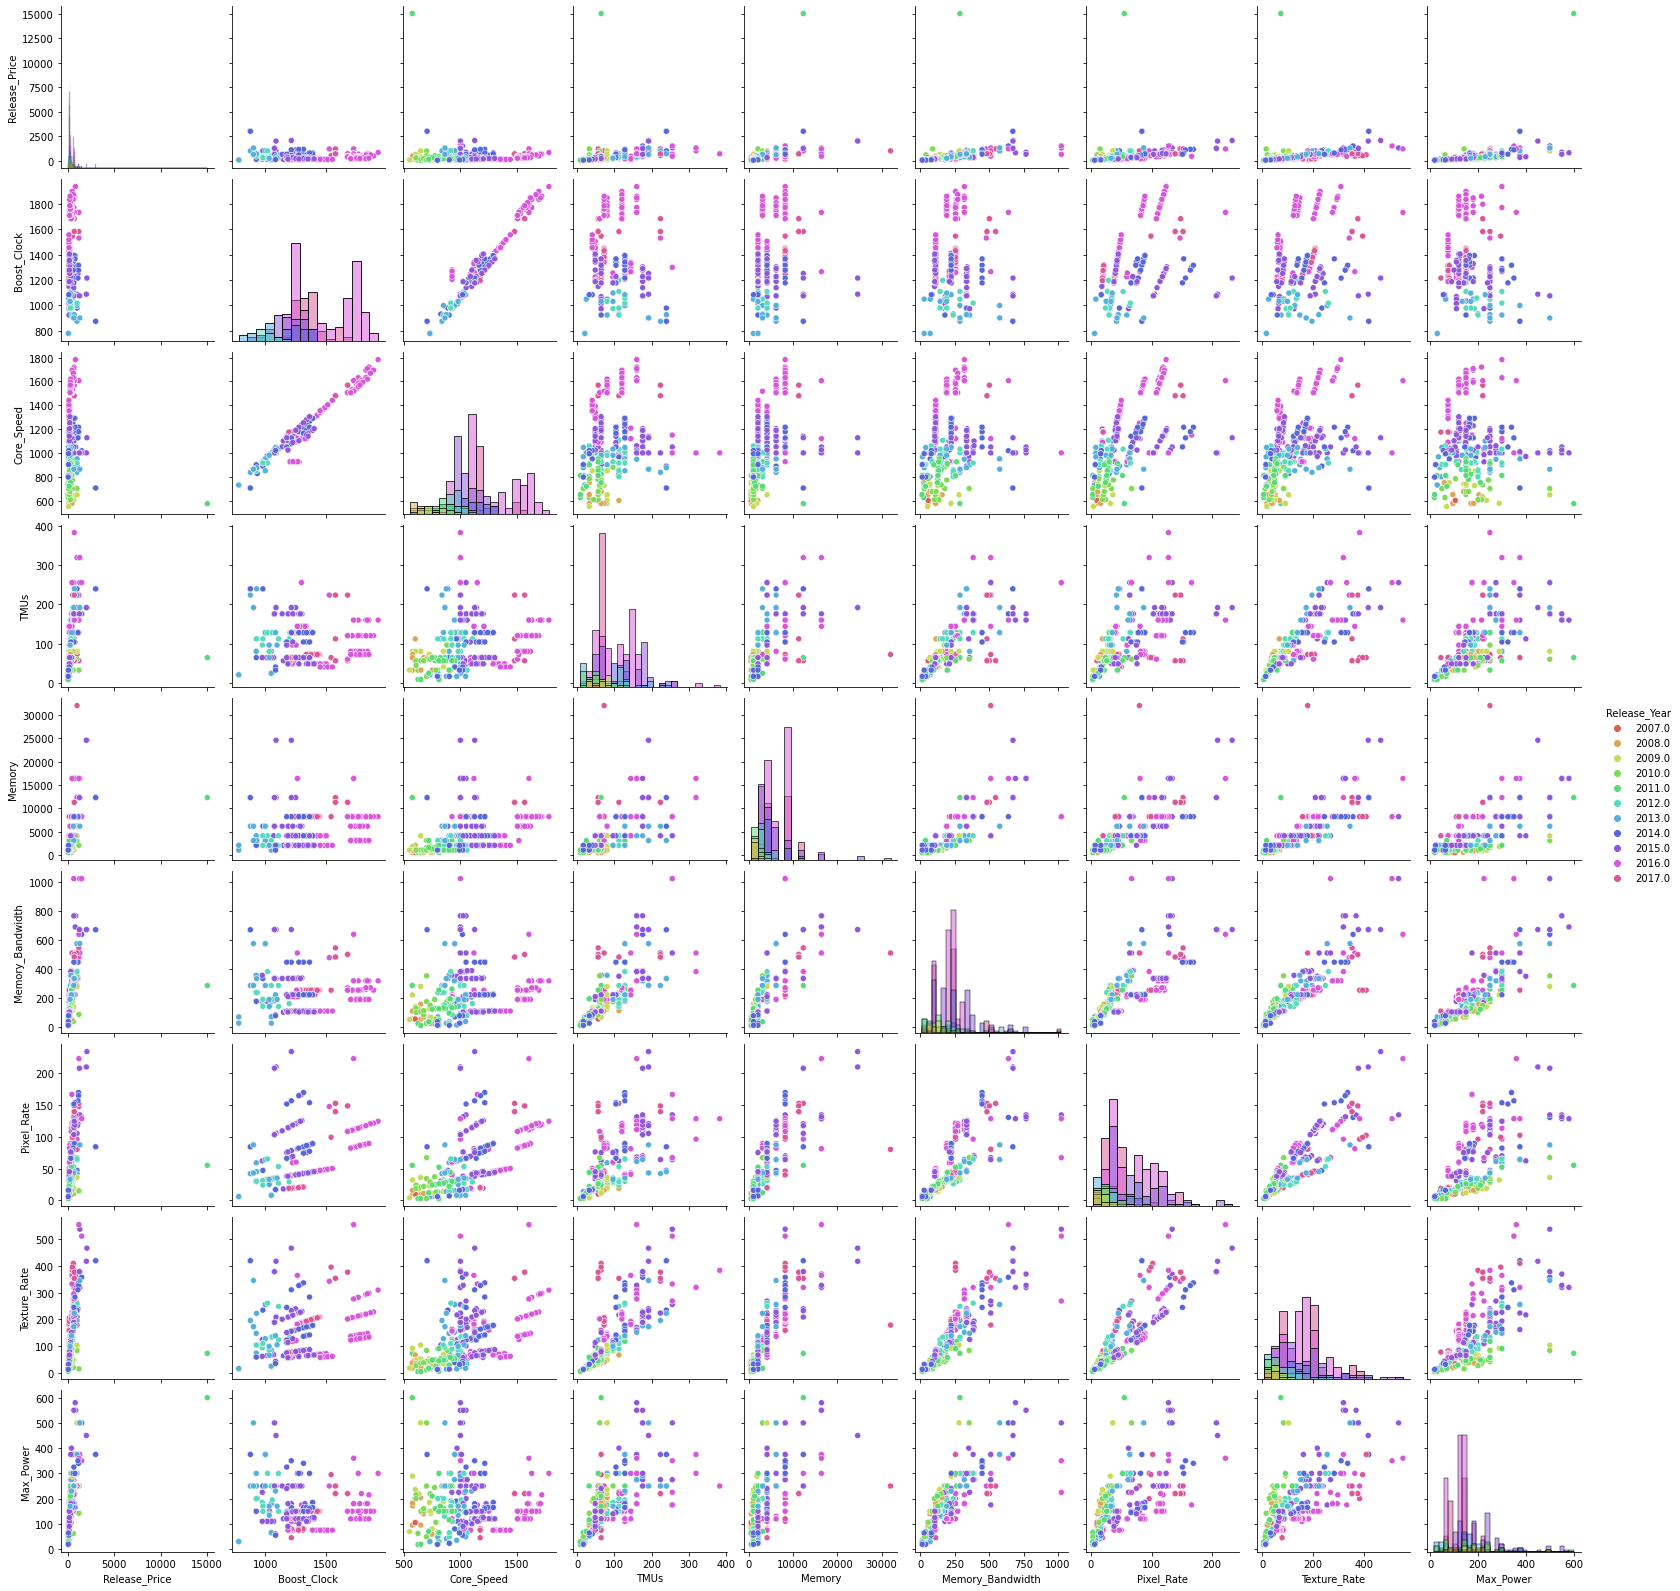

In [15]:
sns.pairplot(df2[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We can notice that for Release_Price there are some outliers in the data that are skewing the scatterplots. Let's remove these outliers.

In [16]:
release_price = df2['Release_Price']

In [17]:
release_price.describe()

count      556.000000
mean       371.562446
std        698.262897
min         23.000000
25%        159.750000
50%        240.000000
75%        421.500000
max      14999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

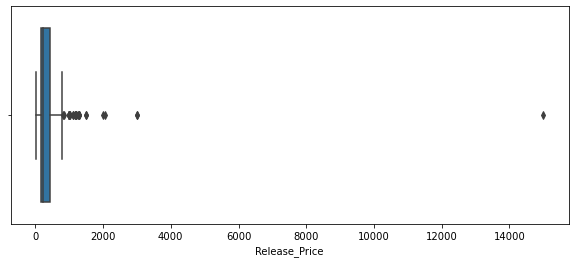

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=release_price, ax=ax)

We take the release prices in the range of 5% quantile and 95% quantile.

In [19]:
release_price_adjusted_mask = release_price.between(release_price.quantile(0.05), release_price.quantile(0.95))

In [20]:
df3 = df2[release_price_adjusted_mask].copy().reset_index(drop=True)

In [21]:
df3['Release_Price'].describe()

count    509.000000
mean     312.272652
std      201.803485
min       99.000000
25%      174.000000
50%      240.000000
75%      398.000000
max      999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

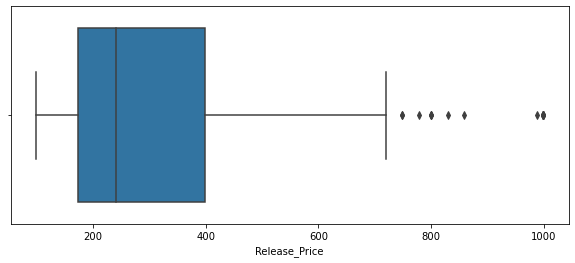

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df3['Release_Price'], ax=ax)

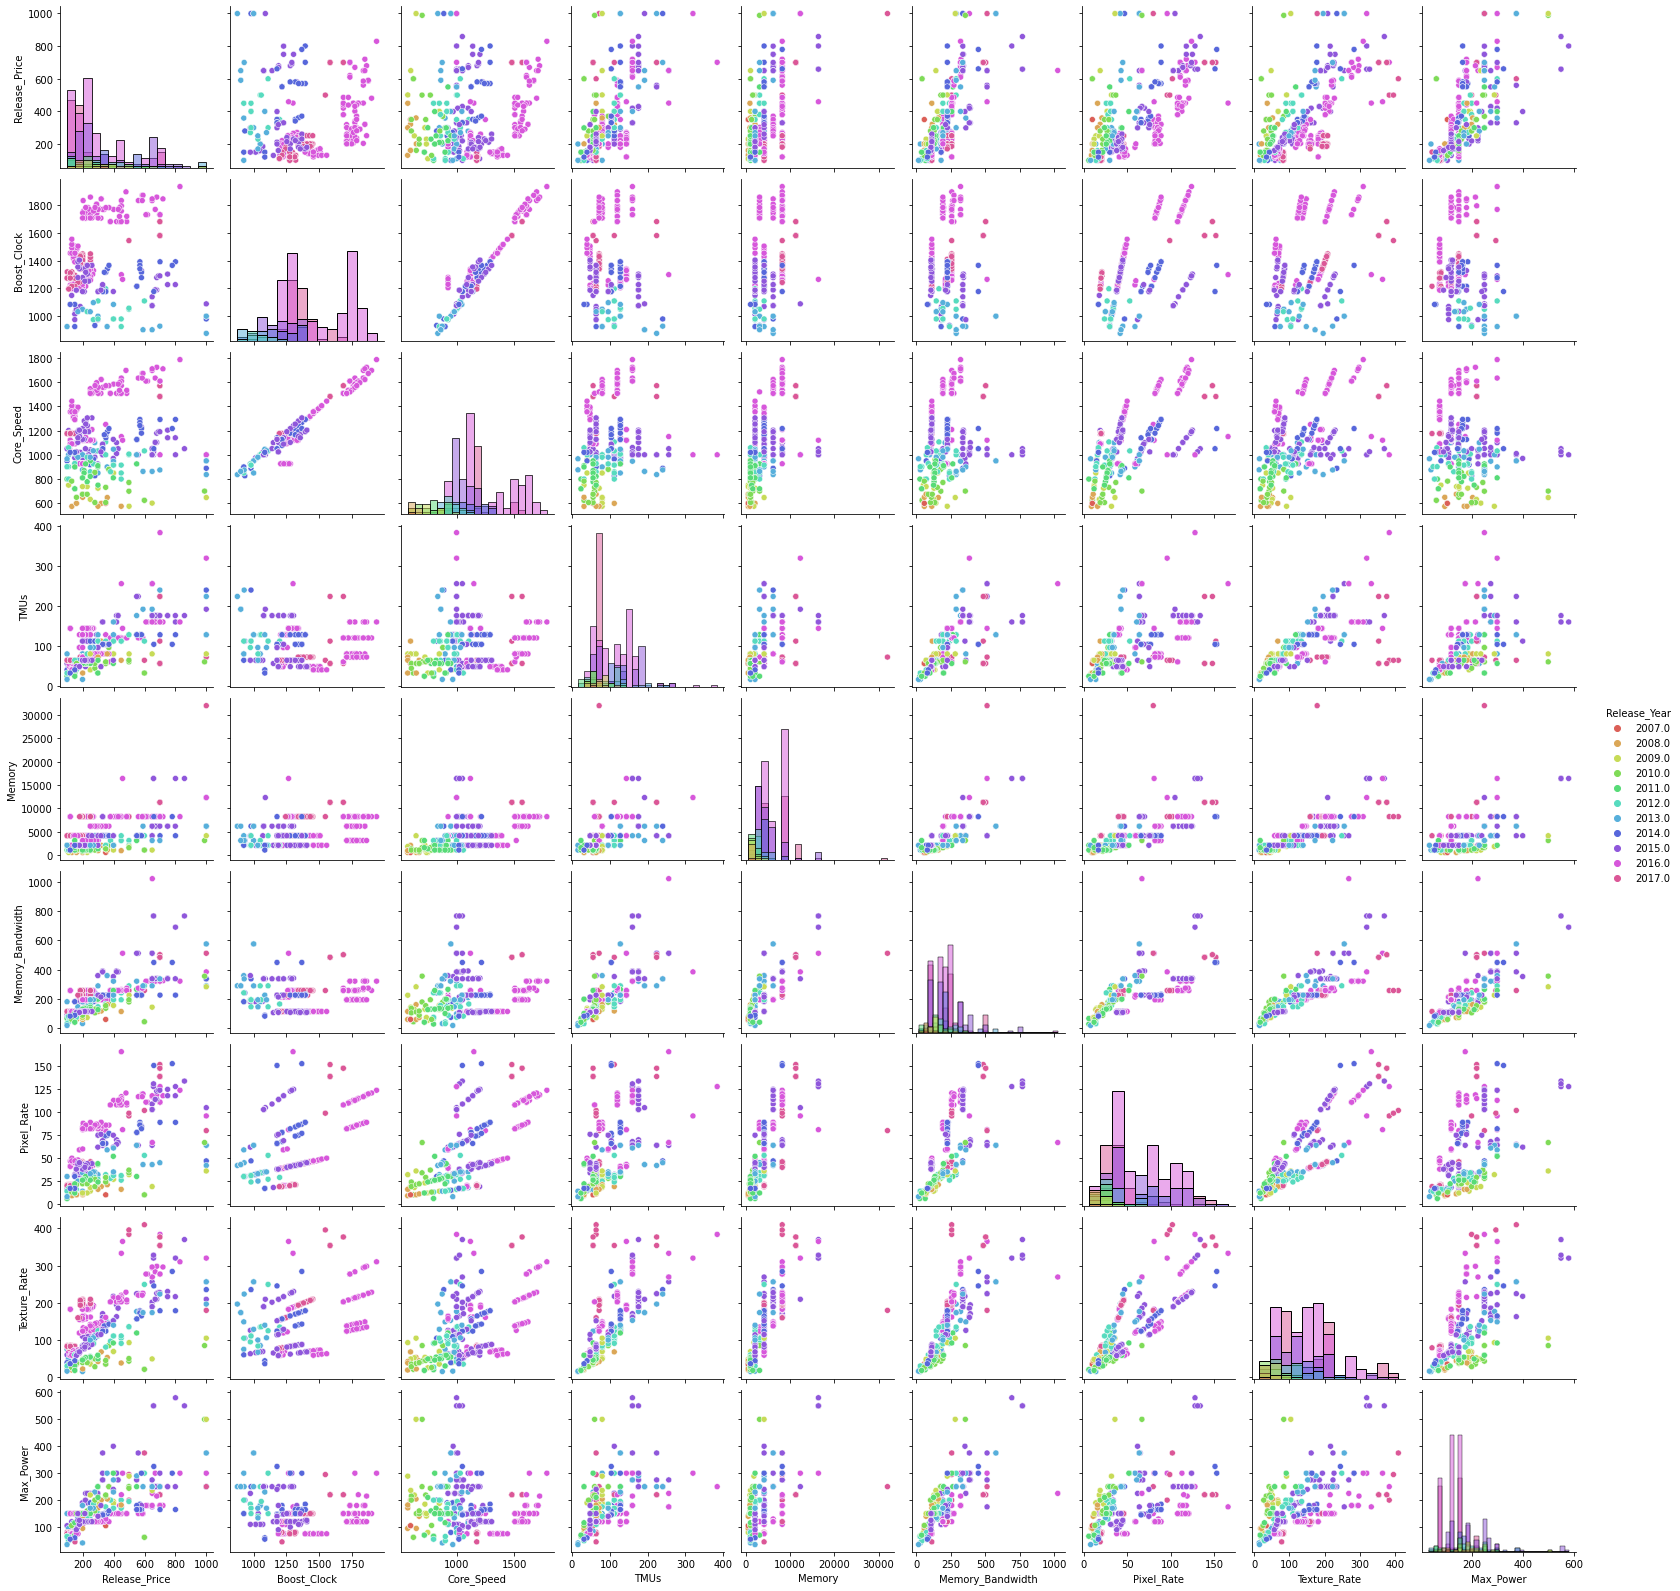

In [23]:
sns.pairplot(df3[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We now have a better visualization of Release_Price

### Grubbs test

Let's try removing Release_Price outliers with Grubbs test. This test isn't ideal for our data set because we have too many data points for this outlier test, but we are doing it for showcase

In [24]:
from outliers import smirnov_grubbs as grubbs
import numpy as np

<AxesSubplot:>

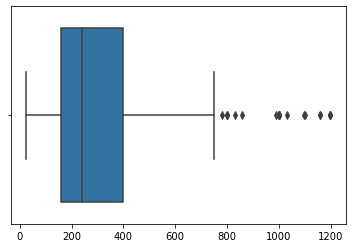

In [25]:
release_price_Grubbs = grubbs.test(np.array(df2['Release_Price']), alpha=0.05)
sns.boxplot(x=release_price_Grubbs)

### Correlations and heat maps

<AxesSubplot:>

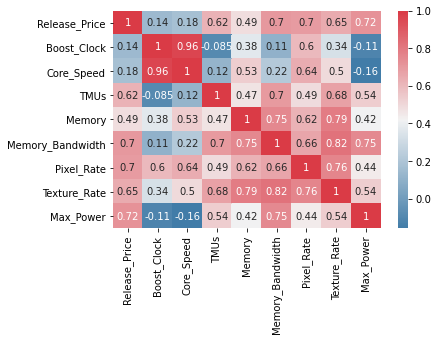

In [26]:
corr = df3[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Since Release_Price stays the same for yearly releases of GPUs but the performance get's better by year as GPUs improve, let's see the pairplot and heatmap for a single year.

<AxesSubplot:xlabel='Release_Year', ylabel='Count'>

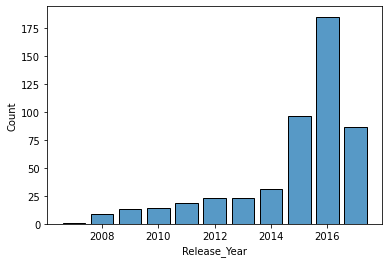

In [27]:
sns.histplot(df3['Release_Year'], discrete=True, shrink=0.8)

In [28]:
df3['Release_Year'].value_counts()

2016.0    185
2015.0     96
2017.0     87
2014.0     31
2013.0     23
2012.0     23
2011.0     19
2010.0     14
2009.0     13
2008.0      9
2007.0      1
Name: Release_Year, dtype: int64

We will choose 2016 since it has the largest number of releases.

In [29]:
df4 = df3[df3['Release_Year'] == 2016].copy().reset_index(drop=True)

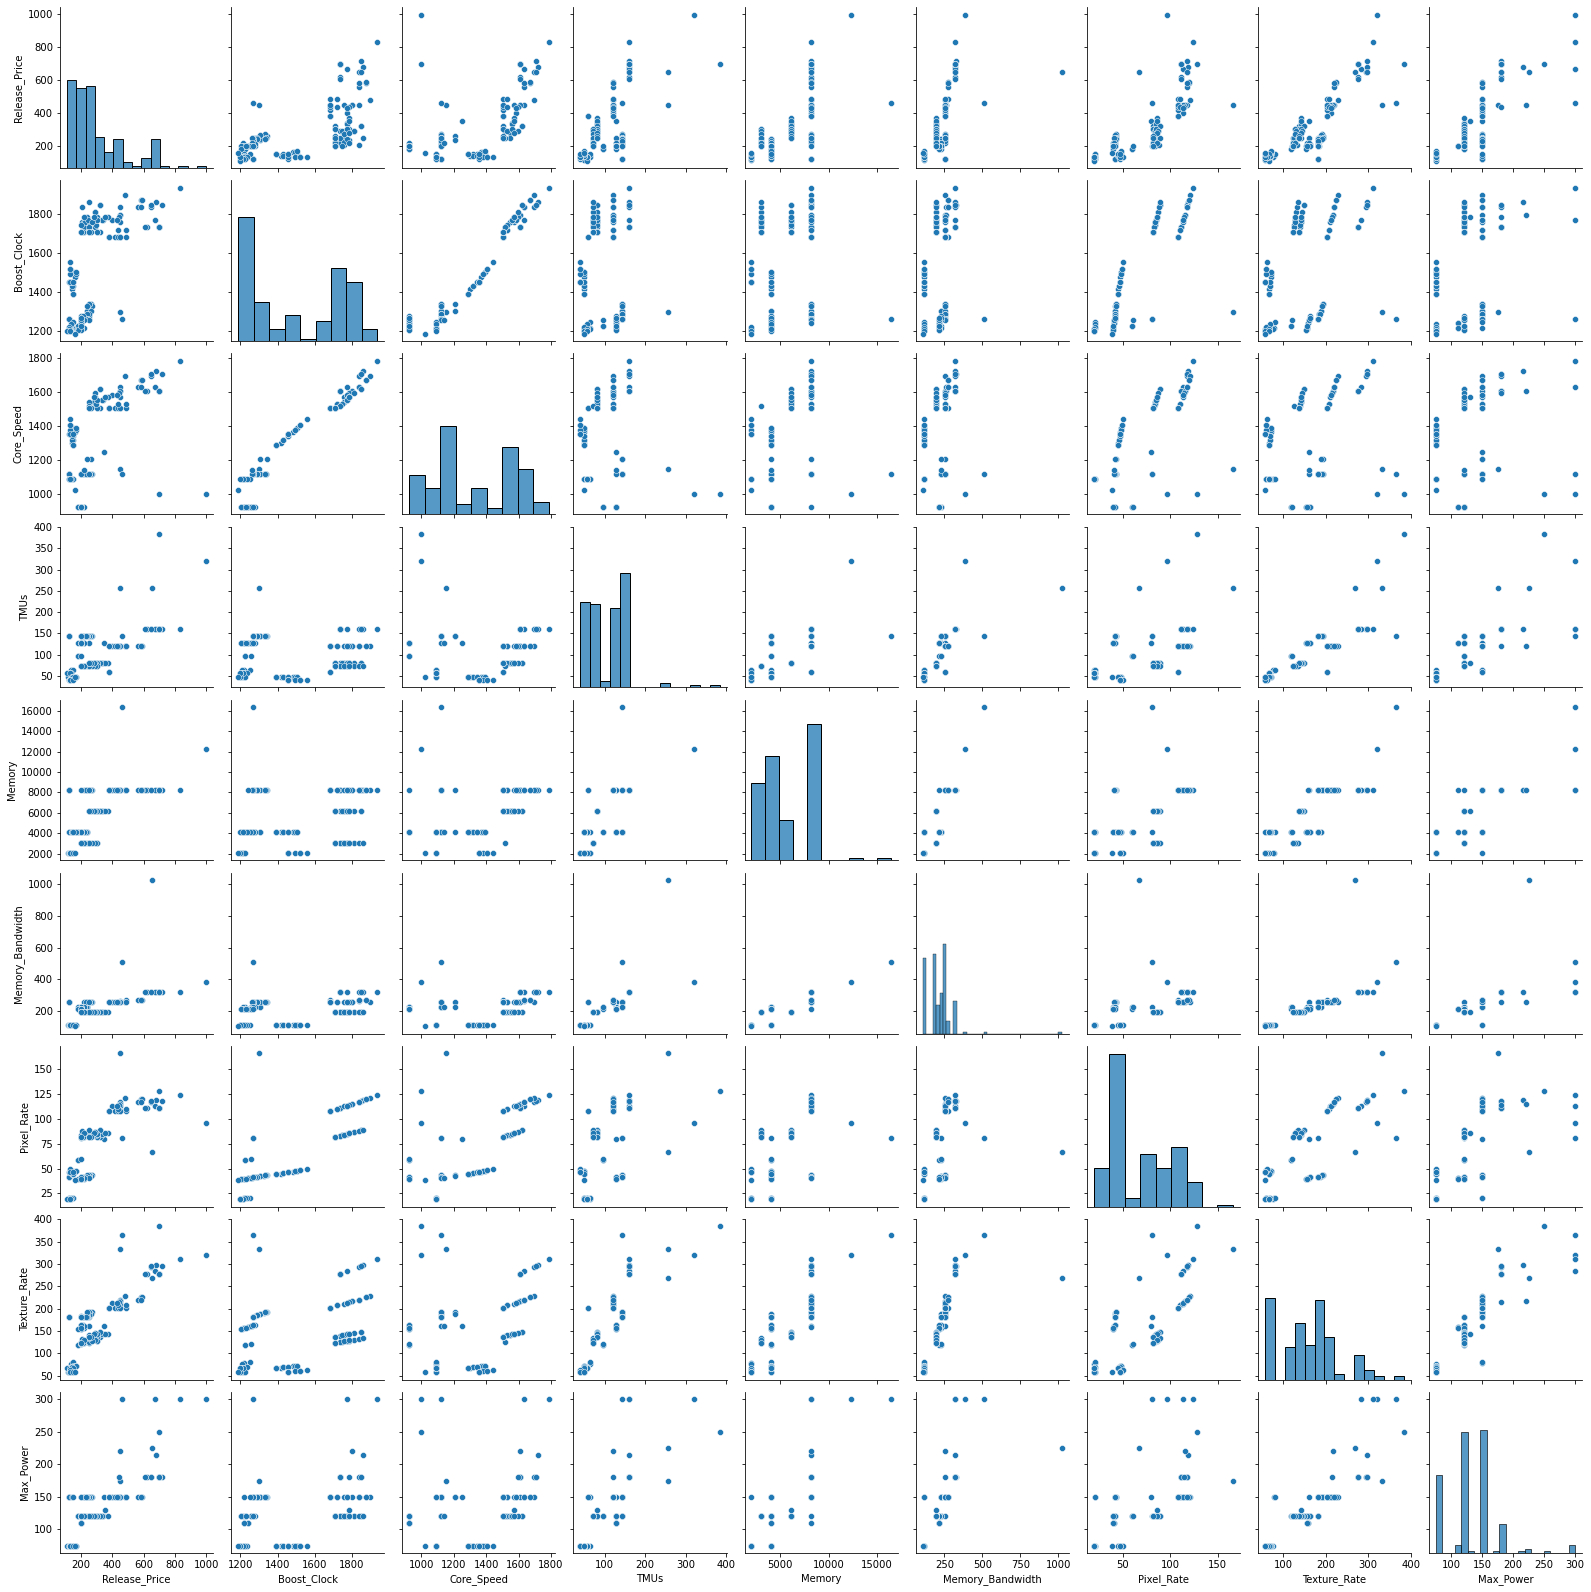

In [30]:
sns.pairplot(df4[regression_columns], diag_kind="hist")

<AxesSubplot:>

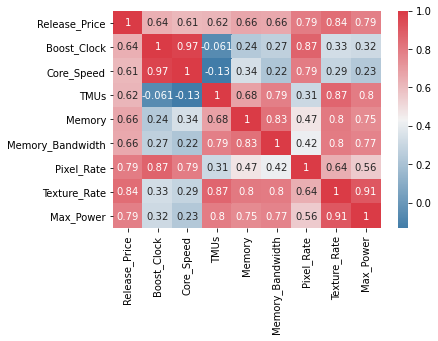

In [31]:
corr = df4[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Correlation between the variables has significantly increased now that we limited the Release_Year.

### Linear regression

In [32]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import CooksDistance

#### All years

##### x=Texture_Rate, y=Release_Price

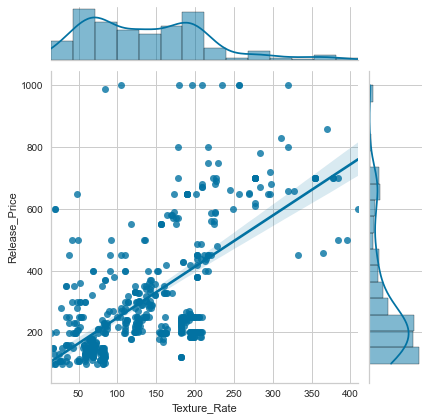

In [33]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df3, kind='reg')

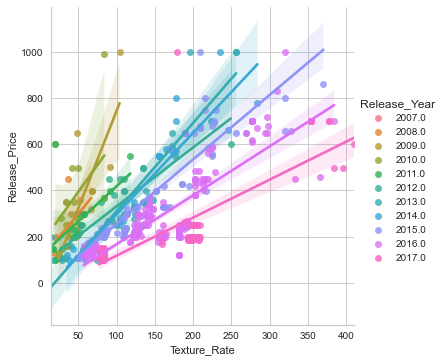

In [34]:
sns.lmplot(x='Texture_Rate', y='Release_Price', data=df3, hue='Release_Year')

We can notice a pattern in the plot, that the more recent the year, the lower the linear regression line is. This means that as GPUs advance we get higher texture rates for lower release prices.

##### x=Pixel_Rate, y=Release_Price

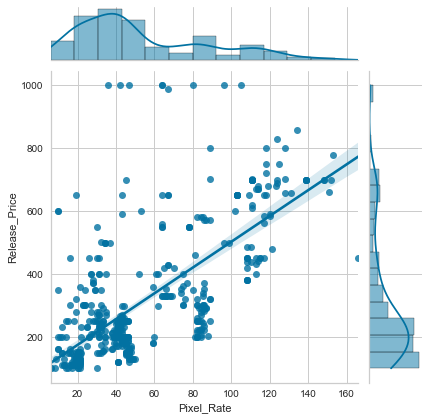

In [35]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df3, kind='reg')

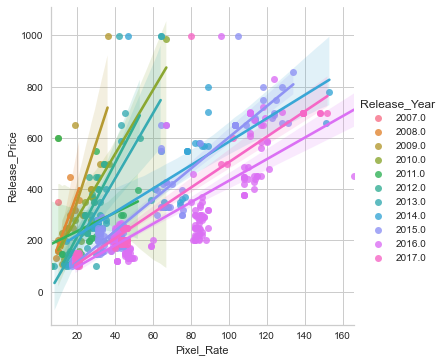

In [36]:
sns.lmplot(x='Pixel_Rate', y='Release_Price', data=df3, hue='Release_Year')

##### x=Memory_Bandwidth, y=Release_Price

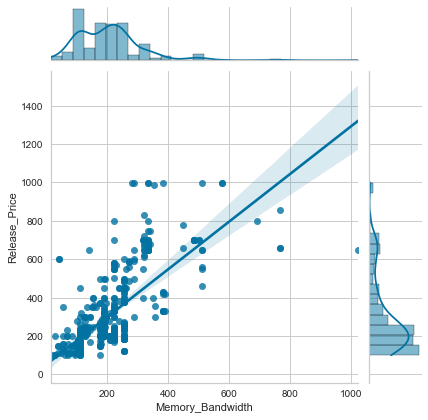

In [37]:
sns.jointplot(x='Memory_Bandwidth', y='Release_Price', data=df3, kind='reg')

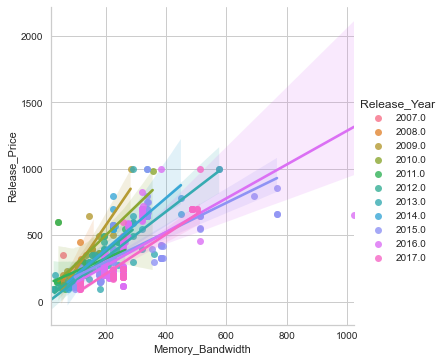

In [38]:
sns.lmplot(x='Memory_Bandwidth', y='Release_Price', data=df3, hue='Release_Year')

##### x=Max_Power, y=Release_Price

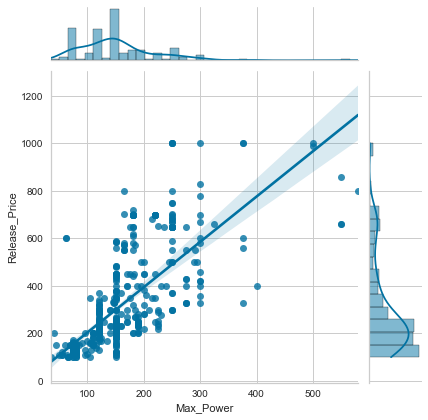

In [39]:
sns.jointplot(x='Max_Power', y='Release_Price', data=df3, kind='reg')

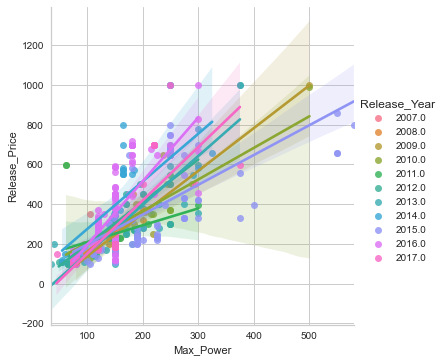

In [40]:
sns.lmplot(x='Max_Power', y='Release_Price', data=df3, hue='Release_Year')

#### 2016

##### x=Texture_Rate, y=Release_Price

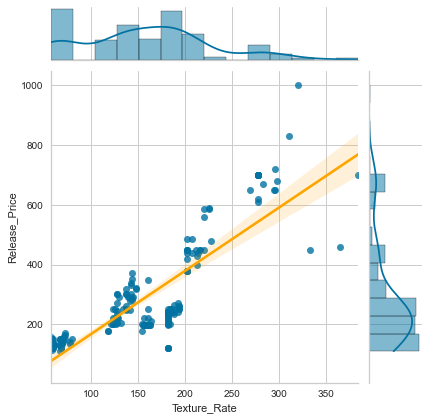

In [41]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df4, kind='reg', line_kws={'color': 'orange'})

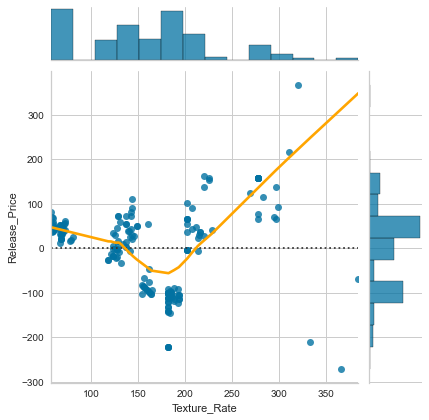

In [42]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df4, kind='resid', lowess=True, line_kws={'color': 'orange'})

In [43]:
regressor1 = sm.OLS(df4['Release_Price'], df4[['Texture_Rate']]).fit()
regressor1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              2166.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                   1.03e-103
Time:                        18:31:35   Log-Likelihood:                         -1106.8
No. Observations:                 185   AIC:                                      2216.
Df Residuals:                     184   BIC:                                      2219.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Texture_Rate     1.8850      0.041     46.539      0.000       1.805       1.965
==============================================================================
Omnibus:                       11.133   Durbin-Watson:                   0.408
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.729
Skew:                           0.402   Prob(JB):                     0.000633
Kurtosis:                       4.125   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We make sure that the linear model from this library is similar to the previous one.

In [44]:
model = LinearRegression()
model.fit(df4[['Release_Price']], df4['Texture_Rate'])
print(f"Score: {model.score(df4[['Release_Price']], df4['Texture_Rate'])}")
print(f'Coef: {model.coef_}, Intercept: {model.intercept_}')

Score: 0.7080376308345833
Coef: [0.33474094], Intercept: 61.42907294694476


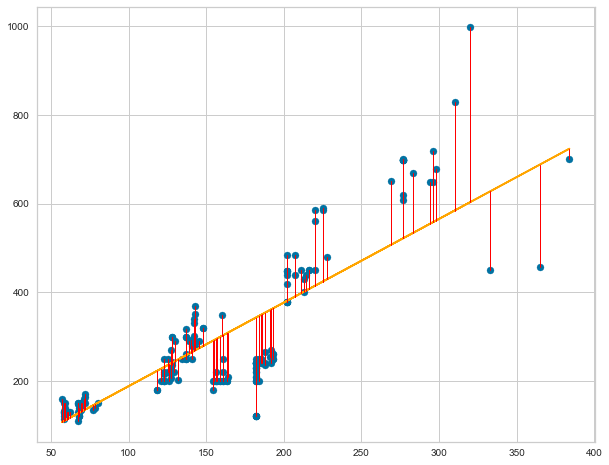

In [45]:
plt.figure(figsize=(10, 8))
plt.scatter(df4['Texture_Rate'], df4['Release_Price'])
predictions = regressor1.predict(df4['Texture_Rate'])
plt.plot(df4['Texture_Rate'], predictions, c='orange')
for x, y_real, y_predict in zip(df4['Texture_Rate'], df4['Release_Price'], predictions):
    plt.plot([x, x], [y_real, y_predict], c='red', lw=1)

Outlier detection and data point influence

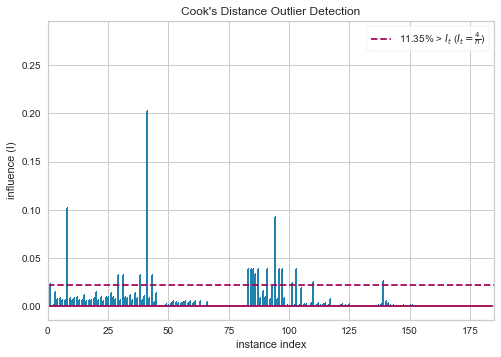

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [46]:
visualizer = CooksDistance()
visualizer.fit(df4[['Texture_Rate']], df4['Release_Price'])
visualizer.show()

To show an example let's use the data without the removed outliers and let's visualize it with Cook's D plot.

In [47]:
df5 = df2[df2['Release_Year'] == 2016].copy().reset_index(drop=True)

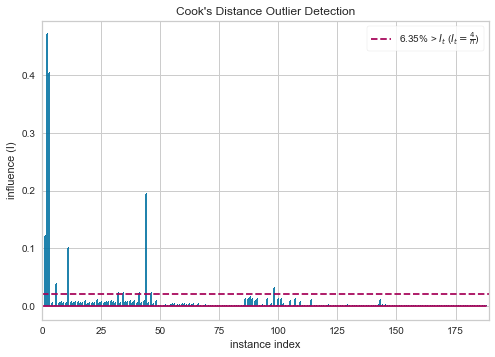

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [48]:
visualizer = CooksDistance()
visualizer.fit(df5[['Texture_Rate']], df5['Release_Price'])
visualizer.show()

From seeing both plots we could conclude that we removed a large portion of the data points with high influence from the original data when removing the outliers. Further investigation would need to be made in order to find out the cause of these outliers. I suppose that it is due to expensive server/workstation GPUs that don't provide much more texture fillrate, but rather provide server grade features useful only in datacenters, hence their larger release price.  
So I can comfortably say that we are not throwing out very important data, because these models of GPUs are rare and produced in small quantities for datacenters.

##### x=Pixel_Rate, y=Release_Price

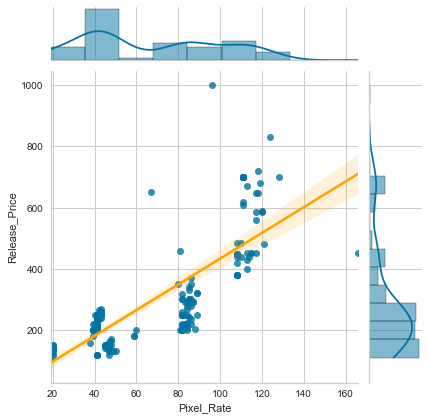

In [49]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df4, kind='reg', line_kws={'color': 'orange'})

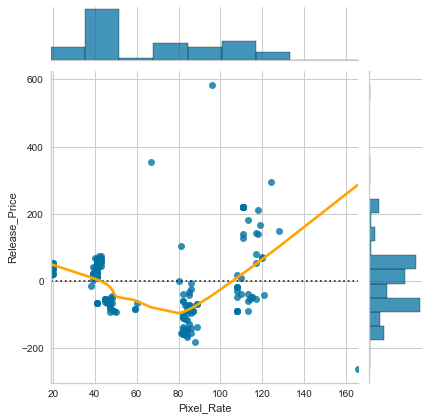

In [50]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df4, kind='resid', lowess=True, line_kws={'color': 'orange'})

In [51]:
regressor2 = sm.OLS(df4['Release_Price'], df4[['Pixel_Rate']]).fit()
regressor2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              1722.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    2.45e-95
Time:                        18:31:37   Log-Likelihood:                         -1126.1
No. Observations:                 185   AIC:                                      2254.
Df Residuals:                     184   BIC:                                      2257.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pixel_Rate     4.3589      0.105     41.494      0.000       4.152       4.566
==============================================================================
Omnibus:                       56.760   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.161
Skew:                           1.202   Prob(JB):                     2.28e-41
Kurtosis:                       7.301   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

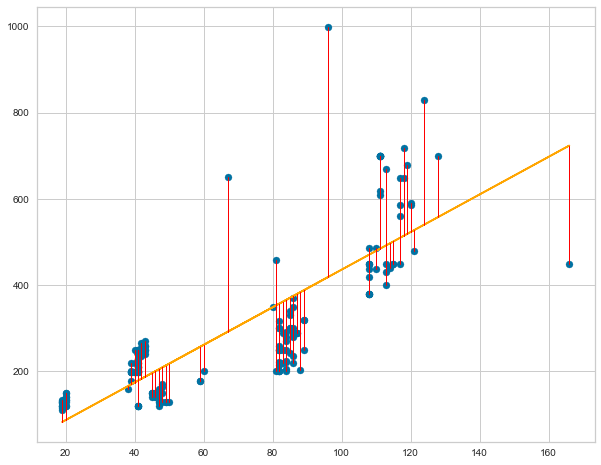

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(df4['Pixel_Rate'], df4['Release_Price'])
predictions = regressor2.predict(df4['Pixel_Rate'])
plt.plot(df4['Pixel_Rate'], predictions, c='orange')
for x, y_real, y_predict in zip(df4['Pixel_Rate'], df4['Release_Price'], predictions):
    plt.plot([x, x], [y_real, y_predict], c='red', lw=1)

##### PCA (Work in progress)

In [84]:
from sklearn.decomposition import PCA

In [94]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(df4[['Texture_Rate', 'Pixel_Rate', 'Max_Power']])
print(pca.explained_variance_ratio_)
regressor2 = sm.OLS(df4['Release_Price'], x_pca).fit()
regressor2.summary()

[0.89065738 0.08011681]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.213
Model:                            OLS   Adj. R-squared (uncentered):              0.204
Method:                 Least Squares   F-statistic:                              24.72
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    3.15e-10
Time:                        20:02:19   Log-Likelihood:                         -1320.3
No. Observations:                 185   AIC:                                      2645.
Df Residuals:                     183   BIC:                                      2651.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8242      0.271      6.734      0.000       1.290       2.359
x2            -1.8267      0.903     -2.022      0.045      -3.609      -0.044
==============================================================================
Omnibus:                       34.580   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.745
Skew:                           0.598   Prob(JB):                     6.11e-32
Kurtosis:                       7.149   Cond. No.                         3.33
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multivariable linear reg
ression

For multivariable linear regression we need to use predictors that have a low correlation. For that we need to take a look at the heatmap from earlier. I chose Core_Speed and Max_Power because they have a correlation of 0.23.

In [53]:
df5 = df4[df4['Core_Speed'].notna() & df4['Max_Power'].notna()].copy().reset_index(drop=True)
df5

Architecture Best_Resolution  Boost_Clock  Core_Speed  \
0             Pascal P100      3840 x 2160          NaN      1000.0   
1    GCN 1.3 Ellesmere XT              NaN          NaN      1250.0   
2      GCN 1.3 Polaris 10              NaN          NaN      1000.0   
3    GCN 1.3 Ellesmere XT      2560 x 1440       1288.0      1120.0   
4    GCN 1.3 Ellesmere XT      2560 x 1440       1338.0      1120.0   
..                     ...             ...          ...         ...   
152           Pascal P107       1600 x 900       1518.0      1404.0   
153           Pascal P107       1600 x 900       1556.0      1442.0   
154           Pascal P107       1600 x 900       1455.0      1354.0   
155           Pascal P107       1600 x 900       1455.0      1354.0   
156  Maxwell GM206-251-A1      1920 x 1080       1188.0      1024.0   

     DVI_Connection Dedicated Direct_X  DisplayPort_Connection  \
0               1.0       Yes  DX 12.1                     3.0   
1               1.0       NaN  DX 12.0                     3.0   
2               2.0       NaN  DX 12.1                     3.0   
3               0.0       Yes  DX 12.0                     3.0   
4               1.0       Yes  DX 12.0                     3.0   
..              ...       ...      ...                     ...   
152             1.0       Yes  DX 12.1                     1.0   
153             1.0       Yes  DX 12.1                     1.0   
154             1.0       Yes  DX 12.1                     1.0   
155             1.0       Yes  DX 12.1                     1.0   
156             1.0       Yes  DX 12.1                     3.0   

     HDMI_Connection Integrated L2_Cache Manufacturer  Max_Power   Memory  \
0                1.0         No   3072KB       Nvidia      300.0  12288.0   
1                1.0        NaN   2048KB          ATI      150.0      NaN   
2                1.0        NaN   4096KB          ATI      250.0      NaN   
3                1.0         No   2048KB          ATI      150.0   8192.0   
4                1.0         No   2048KB          ATI      150.0   8192.0   
..               ...        ...      ...          ...        ...      ...   
152              1.0         No   1024KB       Nvidia       75.0   2048.0   
153              1.0         No   1024KB       Nvidia       75.0   2048.0   
154              1.0         No   1024KB       Nvidia       75.0   2048.0   
155              1.0         No   1024KB       Nvidia       75.0   2048.0   
156              1.0         No   1024KB       Nvidia       75.0   2048.0   

     Memory_Bandwidth Memory_Bus Memory_Speed Memory_Type  \
0               384.0  3072 Bit       500 MHz       HBM-2   
1                 NaN        NaN     1750 MHz         NaN   
2                 NaN        NaN      500 MHz         NaN   
3               256.0   256 Bit      2000 MHz       GDDR5   
4               256.0   256 Bit      2000 MHz       GDDR5   
..                ...        ...          ...         ...   
152             112.1   128 Bit      1752 MHz       GDDR5   
153             112.1   128 Bit      1752 MHz       GDDR5   
154             112.1   128 Bit      1752 MHz       GDDR5   
155             112.1   128 Bit      1752 MHz       GDDR5   
156             105.8   128 Bit      1653 MHz       GDDR5   

                                                  Name Notebook_GPU  Open_GL  \
0              GeForce GTX Titan P 12GB [not released]           No      4.5   
1                    Radeon RX 480X 8GB [not released]           No      4.5   
2                    Radeon RX 490X 8GB [not released]           No      4.5   
3                    Radeon RX 480 XFX Triple X OC 8GB           No      4.5   
4    Radeon RX 480 XFX GTR Hard Swap Black Edition 8GB           No      4.5   
..                                                 ...          ...      ...   
152                        GeForce GTX 1050 MSI OC 2GB           No      4.5   
153                  GeForce GTX 1050 MSI Gaming X 2GB           No   

In [54]:
regressor3 = sm.OLS(df5['Release_Price'], df5[['Core_Speed', 'Max_Power']]).fit()
regressor3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.884
Method:                 Least Squares   F-statistic:                              599.8
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    1.08e-73
Time:                        18:31:37   Log-Likelihood:                         -975.77
No. Observations:                 157   AIC:                                      1956.
Df Residuals:                     155   BIC:                                      1962.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Core_Speed     0.0361      0.023      1.576      0.117      -0.009       0.081
Max_Power      2.0529      0.215      9.549      0.000       1.628       2.478
==============================================================================
Omnibus:                       26.257   Durbin-Watson:                   0.470
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.411
Skew:                           1.078   Prob(JB):                     5.56e-08
Kurtosis:                       3.676   Cond. No.                         29.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Residuals

Let's manually plot the residuals

In [55]:
predicted = regressor3.predict(df5[['Core_Speed', 'Max_Power']])
actual = df5['Release_Price']
residual = actual - predicted
residual

0      346.994129
1       -4.099943
2      150.630217
3     -103.403128
4      -88.403128
          ...    
152    -74.694730
153    -76.067645
154    -72.888263
155    -52.888263
156    -31.965579
Length: 157, dtype: float64

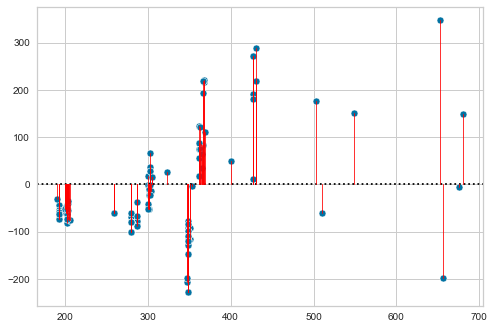

In [56]:
sns.scatterplot(x=predicted, y=residual)
plt.axhline(0, c='black', linestyle=':')
for x_predict, y_residual in zip(predicted, residual):
    plt.plot([x_predict, x_predict], [0, y_residual], c='red', lw=1, alpha=0.8)

### Logistic regression

#### Counts

<AxesSubplot:xlabel='count', ylabel='Manufacturer'>

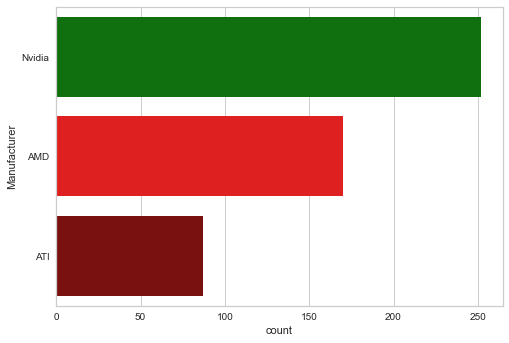

In [76]:
sns.countplot(y='Manufacturer', data=df3)

#### Pair plots

In [57]:
manufacturer_palette = sns.set_palette(sns.color_palette(['green', 'red', 'darkred']))

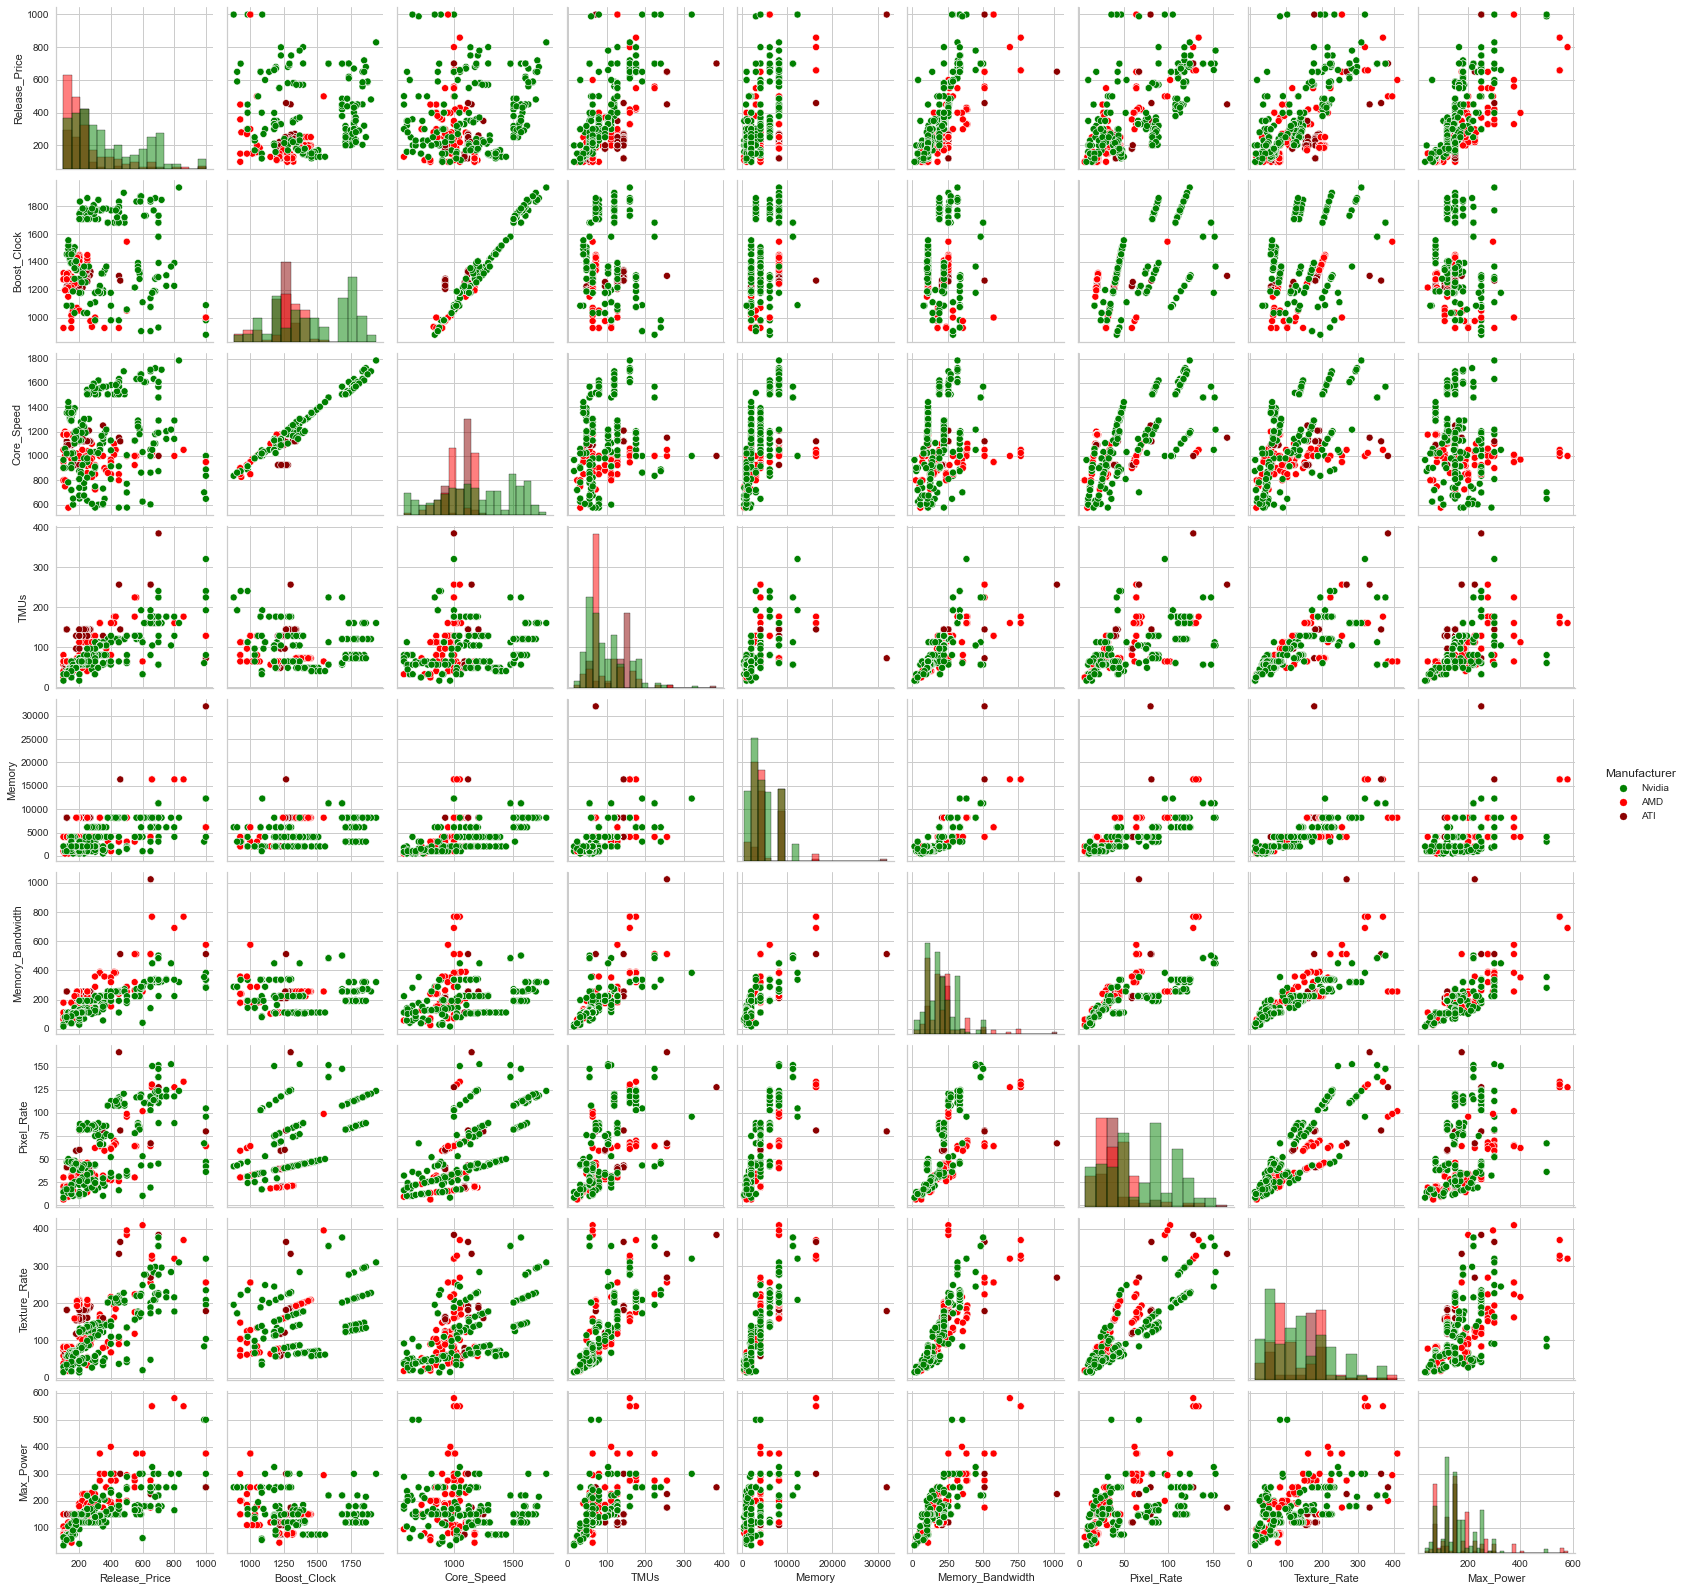

In [58]:
sns.pairplot(df3[regression_columns + ['Manufacturer']], hue='Manufacturer', diag_kind='hist', palette=manufacturer_palette)

ATI was aquired by AMD in 2006. So let's remove rows where Manufacturer == ATI.

In [59]:
df6 = df3[df3['Manufacturer'] != 'ATI'].copy()

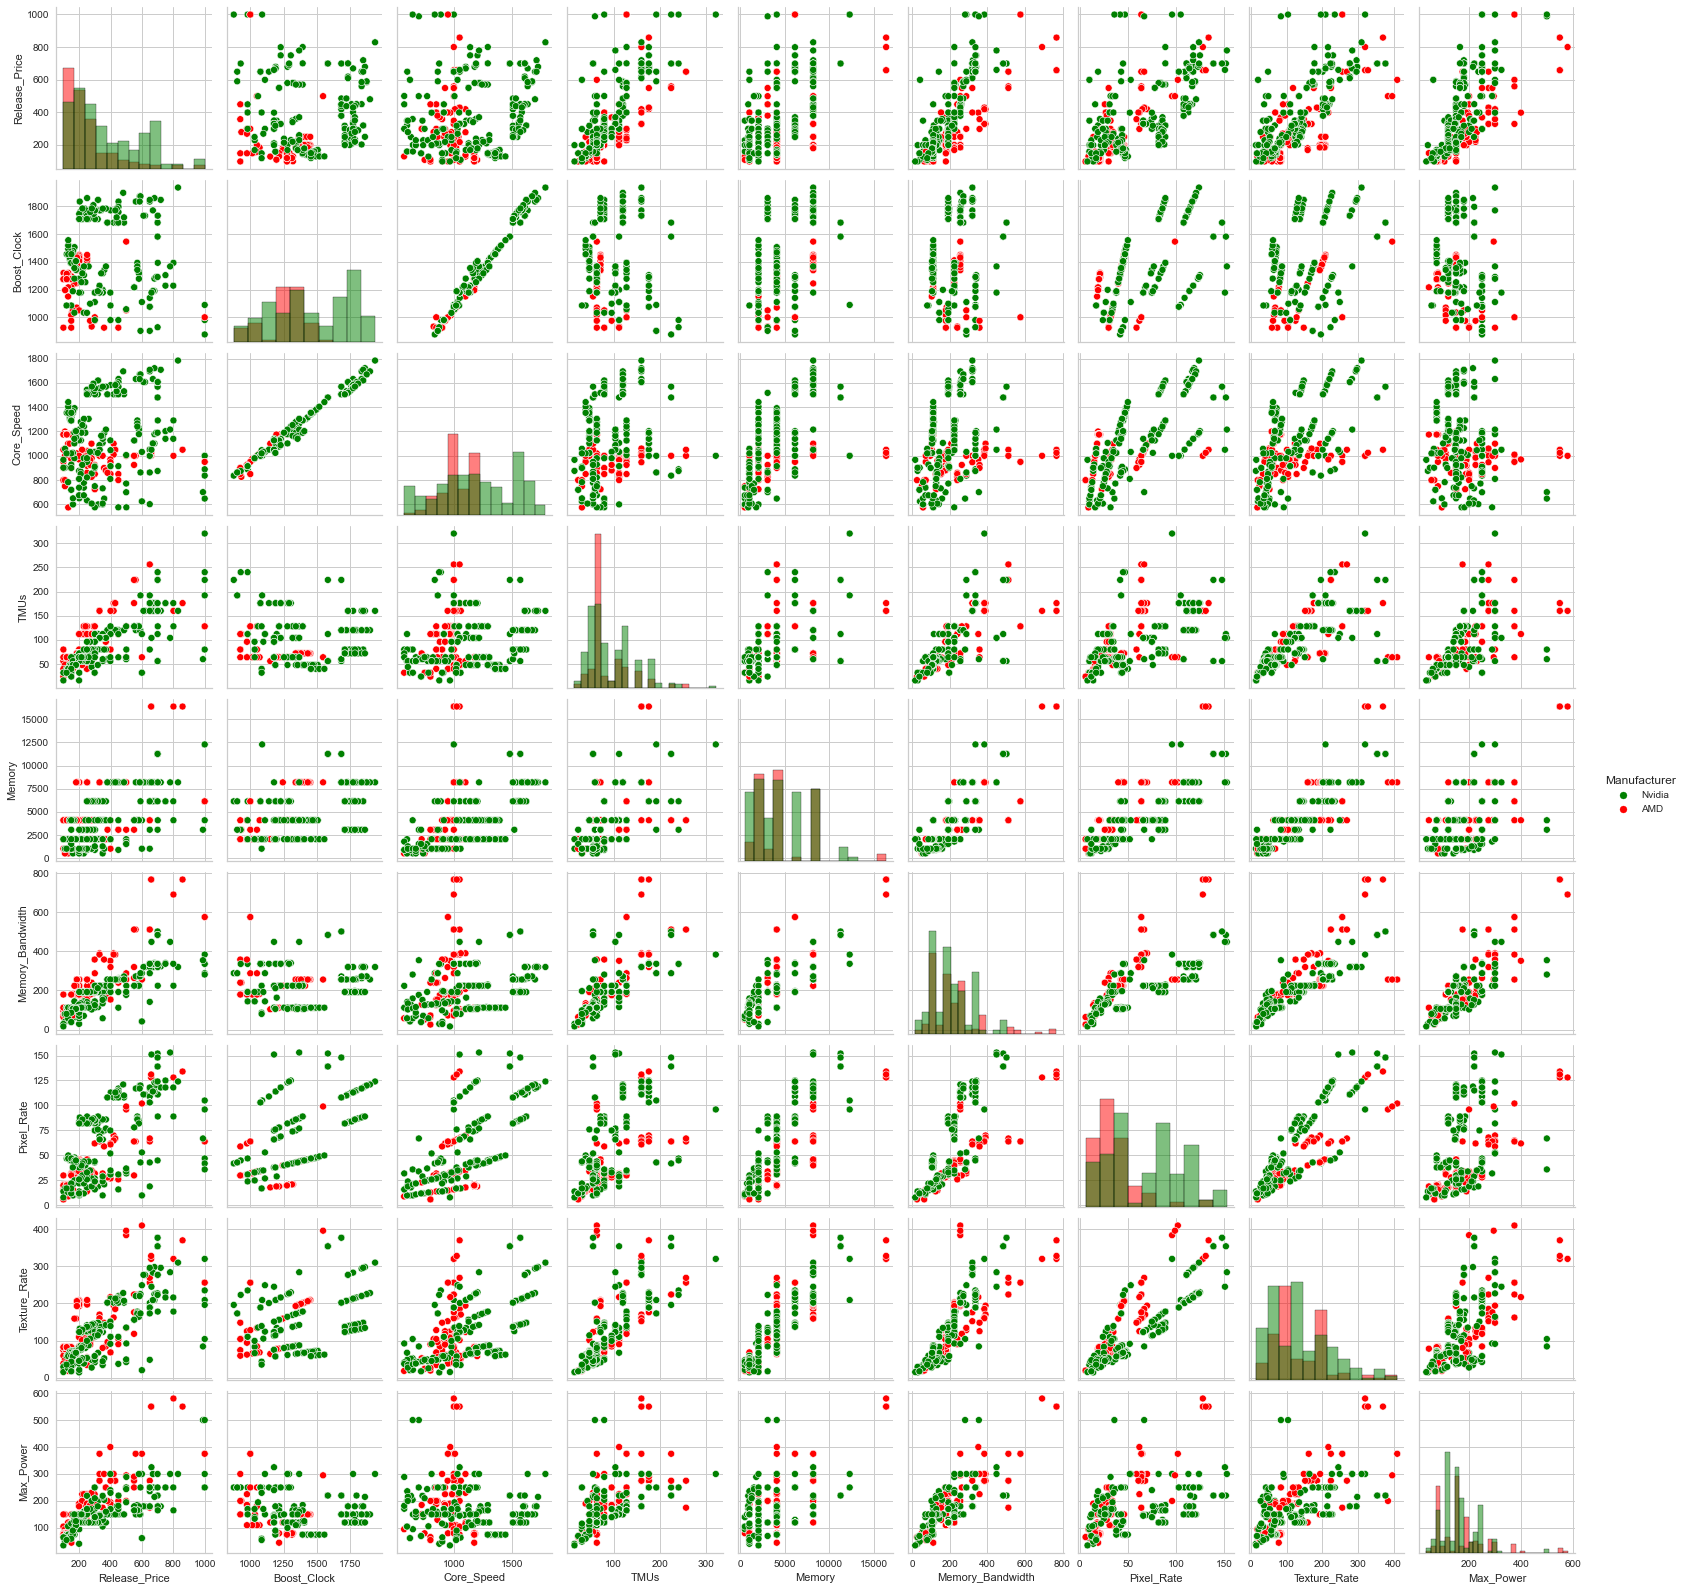

In [60]:
sns.pairplot(df6[regression_columns + ['Manufacturer']], hue='Manufacturer', diag_kind='hist')

#### Correlations and heat map

In [61]:
df7 = pd.concat([df6, pd.get_dummies(df6['Manufacturer'])], axis=1)
del df7['Manufacturer']
df7

Architecture Best_Resolution  Boost_Clock  Core_Speed  \
0    Maxwell GM200-400-A1      3840 x 2160       1089.0      1000.0   
1             Pascal P100      3840 x 2160          NaN      1000.0   
2     Kepler GK110-430-B1      2560 x 1440        980.0       889.0   
3     Kepler GK110-400-A1      2560 x 1440        876.0       837.0   
4           R700 RV790 XT      1920 x 1080          NaN       960.0   
..                     ...             ...          ...         ...   
504     Maxwell GM206-250      1920 x 1080       1405.0      1203.0   
505   Kepler GK104-225-A2      1920 x 1080       1098.0      1033.0   
506   Kepler GK104-225-A2      1920 x 1080       1032.0       980.0   
507  Maxwell GM107-400-A2       1600 x 900       1085.0      1020.0   
508  Maxwell GM107-300-A2       1600 x 900       1085.0      1020.0   

     DVI_Connection Dedicated Direct_X  DisplayPort_Connection  \
0               1.0       Yes  DX 12.1                     NaN   
1               1.0       Yes  DX 12.1                     3.0   
2               2.0       Yes  DX 12.0                     NaN   
3               2.0       Yes  DX 12.0                     NaN   
4               2.0       Yes  DX 10.1                     NaN   
..              ...       ...      ...                     ...   
504             2.0       Yes  DX 12.1                     3.0   
505             1.0       Yes  DX 12.0                     2.0   
506             2.0       Yes  DX 12.0                     NaN   
507             2.0       Yes  DX 12.0                     0.0   
508             2.0       Yes  DX 12.0                     NaN   

     HDMI_Connection Integrated L2_Cache  Max_Power   Memory  \
0                1.0         No   3072KB      250.0  12288.0   
1                1.0         No   3072KB      300.0  12288.0   
2                1.0         No   1536KB      250.0   6144.0   
3                1.0         No   1536KB      250.0   6144.0   
4                0.0         No      0KB      190.0   1024.0   
..               ...        ...      ...        ...      ...   
504              1.0         No   1024KB      125.0   2048.0   
505              1.0         No    512KB      170.0   2048.0   
506              1.0         No    512KB      170.0   2048.0   
507              1.0         No   2048KB       60.0   2048.0   
508              1.0         No   2048KB       55.0   1024.0   

     Memory_Bandwidth Memory_Bus Memory_Speed Memory_Type  \
0               336.6   384 Bit      1753 MHz       GDDR5   
1               384.0  3072 Bit       500 MHz       HBM-2   
2               336.0   384 Bit      1750 MHz       GDDR5   
3               288.4   384 Bit      1502 MHz       GDDR5   
4               134.4   256 Bit      1050 MHz       GDDR5   
..                ...        ...          ...         ...   
504             105.8   128 Bit      1653 MHz       GDDR5   
505             192.3   256 Bit      1502 MHz       GDDR5   
506             192.3   256 Bit      1502 MHz       GDDR5   
507              86.4   128 Bit      1350 MHz       GDDR5   
508              80.0   128 Bit      1250 MHz       GDDR5   

                                             Name Notebook_GPU  Open_GL  \
0                             GeForce GTX Titan X           No      4.5   
1         GeForce GTX Titan P 12GB [not released]           No      4.5   
2                 GeForce GTX Titan Black Edition           No      4.5   
3                               GeForce GTX Titan           No      4.5   
4       Radeon HD 4890 Sapphire Toxic 1GB Edition           No      3.3   
..                                            ...          ...      ...   
504  GeForce GTX 950 EVGA FTW ACX 2.0 2GB Edition           No      4.5   
505    GeForce GTX 760 MSI Gaming ITX 2GB Edition           No      4.5   
506                               GeForce GTX 760           No      4.5   
507                            GeForce GTX 750 Ti           No      4.5   
508                               GeForce

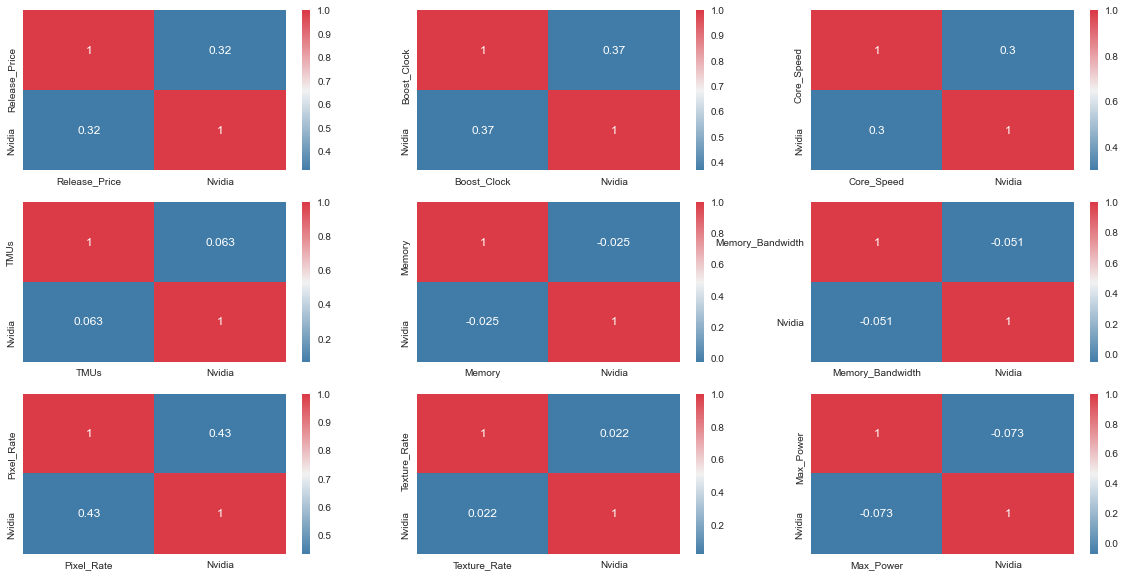

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for col, ax in zip(regression_columns, axes.flatten()):
    corr = df7[[col, 'Nvidia']].corr()
    sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True), ax=ax)

We see that the strongest correlation to wether the Manufacturer is Nvidia is Pixel_Rate, so we will use that for the logistic regression

#### Model

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
x = df7[['Pixel_Rate']]
y = df7['Nvidia']
model = LogisticRegression(random_state=0).fit(x, y)
print(f"Score: {model.score(x, y)}")
print(f'Coef: {model.coef_}, Intercept: {model.intercept_}')

Score: 0.6895734597156398
Coef: [[0.03263501]], Intercept: [-1.26929174]


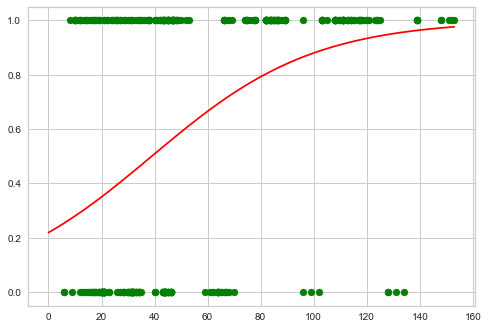

In [78]:
x_range = int(max(df7['Pixel_Rate']) + 1)
Xs = [i for i in range(x_range)]
Ys = [model.predict_proba([[value]])[0][1] for value in range(x_range)]

plt.scatter(x, y)
plt.plot(Xs, Ys, color='red')

<AxesSubplot:xlabel='Pixel_Rate', ylabel='Nvidia'>

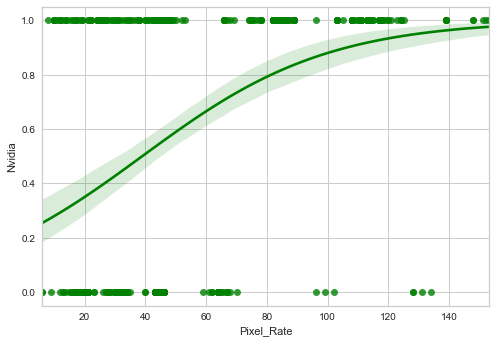

In [68]:
sns.regplot(x='Pixel_Rate', y='Nvidia', data=df7, logistic=True)